In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('drive/MyDrive/*')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. EDA

In [ ]:
df = pd.read_csv('validator_slosts.csv', index_col='slot_number')
df.head(10)

,slot_date,validator_index,validators_cnt
slot_number,,,
1,2020-12-01,19026,21335
2,2020-12-01,11516,21335
3,2020-12-01,20640,21335
4,2020-12-01,11308,21335
6,2020-12-01,11158,21335
8,2020-12-01,12725,21335
9,2020-12-01,8296,21335
10,2020-12-01,2268,21335
11,2020-12-01,308,21335


In [ ]:
df['slot_date'] = pd.to_datetime(df['slot_date'])

In [ ]:
date_index_g = df.groupby(['slot_date',	'validator_index'])
date_index_count = date_index_g.count()
date_index_count.head()

validators_cnt
slot_date  validator_index                
2020-12-01 8                             1
           13                            1
           15                            1
           27                            1
           28                            1

In [ ]:
(date_index_count['validators_cnt']>=2).sum()

120178

In [ ]:
(date_index_count['validators_cnt']>=5).sum()

6

### There are 120178 cases where the same validator was chosen 2 or more times at the same day, and 6 cases for 5 times and more

In [ ]:
((date_index_g['validators_cnt'].max()-date_index_g['validators_cnt'].min())).unique()

array([0])

In [ ]:
val_count_g = df.groupby('validator_index')['validators_cnt']
val_count_g.agg([min, max])[val_count_g.count()>1]

,min,max
validator_index,,
1,22234,664195
2,22234,525685
3,22234,600651
4,39303,651987
5,24023,795827
...,...,...
1047553,884045,888419
1048199,879992,888419
1048900,884045,886194


### Every day the probability of a validator to be chosen is the same for every slot. But not necessarily the same for every day

In [ ]:
val_idx_minmax = df.groupby('validator_index')['slot_date'].agg([min, max])

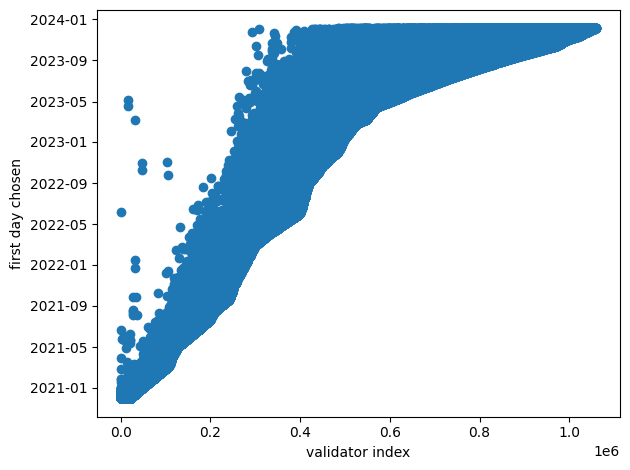

In [ ]:
val_idx_minmax = df.groupby('validator_index')['slot_date'].agg([min, max])
plt.scatter(val_idx_minmax.index, val_idx_minmax['min'])
plt.xlabel('validator index')
plt.ylabel('first day chosen')
plt.tight_layout()
plt.show()

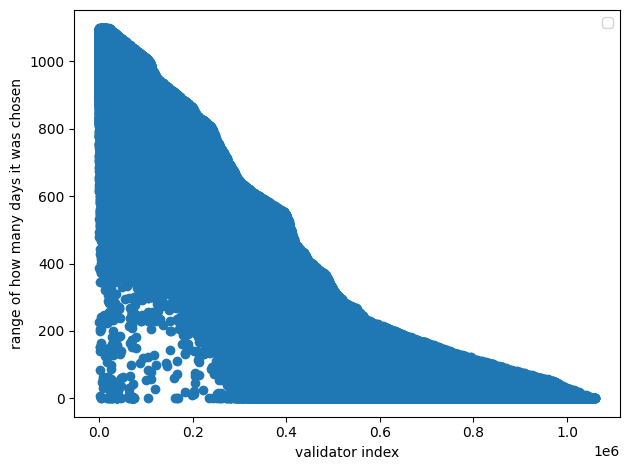

validator_index
1          953 days
2          814 days
3          913 days
4          927 days
5         1014 days
             ...   
1058837      0 days
1059258      0 days
1059305      0 days
1059412      0 days
1060116      0 days
Length: 841954, dtype: timedelta64[ns]


In [ ]:
dif = val_idx_minmax['max']-val_idx_minmax['min']
plt.scatter(dif.index, dif.dt.days)
plt.legend()
plt.xlabel('validator index')
plt.ylabel('range of how many days it was chosen')
plt.tight_layout()
plt.show()
print(dif)

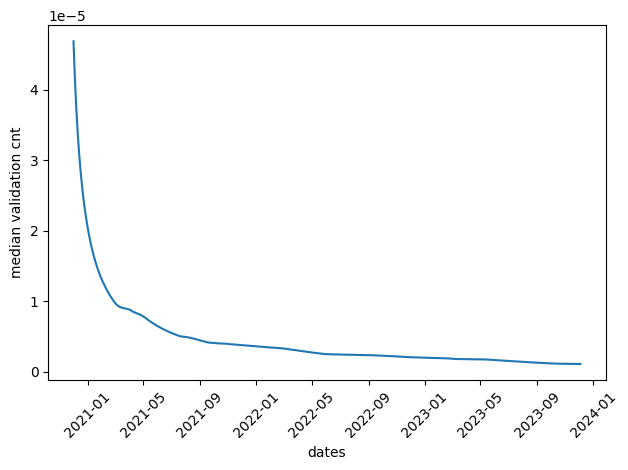

In [ ]:
plt.plot(df.groupby('slot_date')['validators_cnt'].apply(lambda x: (1/x).median()))
plt.xlabel('dates')
plt.xticks(rotation=45)
plt.ylabel('median validation cnt')
plt.tight_layout()
plt.show()

### amount of validators grows with time and the median probability to be chosen goes exponentialy down

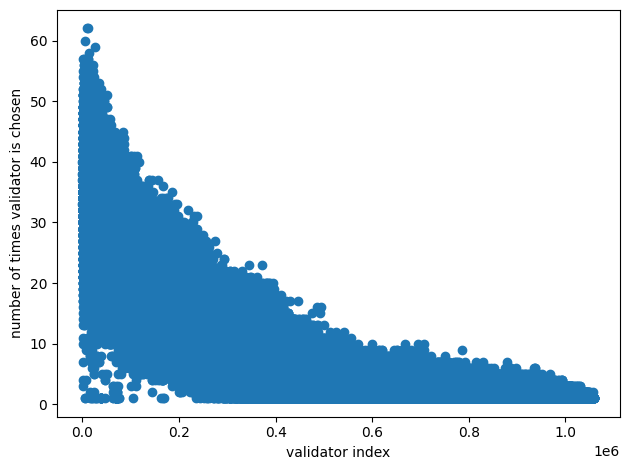

validator_index
11027      62
9053       62
4488       60
25992      59
13150      58
           ..
730193      1
730194      1
730195      1
730198      1
1060116     1
Name: validators_cnt, Length: 841954, dtype: int64


In [ ]:
val_count = val_count_g.count()
plt.scatter(val_count.index, val_count)
plt.xlabel('validator index')
plt.ylabel('number of times validator is chosen')
plt.tight_layout()
plt.show()
print(val_count.sort_values(ascending=False))

### Some validators are chosen more often than others. Validators at the begining of indexing tend to be more frequent. Which already sugests that the there may be a pattern.

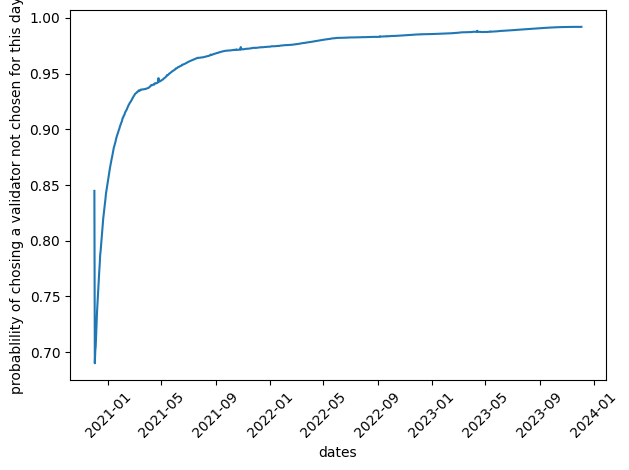

In [ ]:
df_unseen_vs = df.groupby('slot_date')['validators_cnt'].apply(lambda ser_x: 1-(1/ser_x).sum())
plt.plot(df_unseen_vs)
plt.xlabel('dates')
plt.xticks(rotation=45)
plt.ylabel('probablility of chosing a validator not chosen for this day')
plt.tight_layout()
plt.show()

In [ ]:
df['validators_cnt'].min()

21335

In [ ]:
from scipy.stats import binom
binom.pmf(2, 7200, 1/21335)

0.04063158092314389

### getting 2 counts of the same validator at the same day even for the largest probability is very unlikely.

# Fitting: According to the description given in the task, the choice of a validator supposed to follow Binomial distribution with the probability value assigned for each specific validator. Let's calculate p-value for the validators that were chosen twice or more. Those who get p-value less than 0.05 will be considered suspitios and will be investigated further

In [ ]:
multiindex2 = date_index_count[date_index_count['validators_cnt']>=2].index
date_num_slots = df.groupby('slot_date')['validator_index'].count()
date_num_slots

slot_date
2020-12-01    3312
2020-12-02    6891
2020-12-03    6915
2020-12-04    7075
2020-12-05    7084
              ... 
2023-11-30    7145
2023-12-01    7151
2023-12-02    7157
2023-12-03    7130
2023-12-04    7150
Name: validator_index, Length: 1099, dtype: int64

In [ ]:
p_values2 = []
suspitios_pairs = []
for i, j in multiindex2:
  p_val = binom.pmf(date_index_count.loc[(i, j)], date_num_slots.loc[i], 1/j)
  p_values2.append(p_val)
  if p_val<0.05:
    suspitios_pairs.append((i, j))
p_values2 = np.array(p_values2)

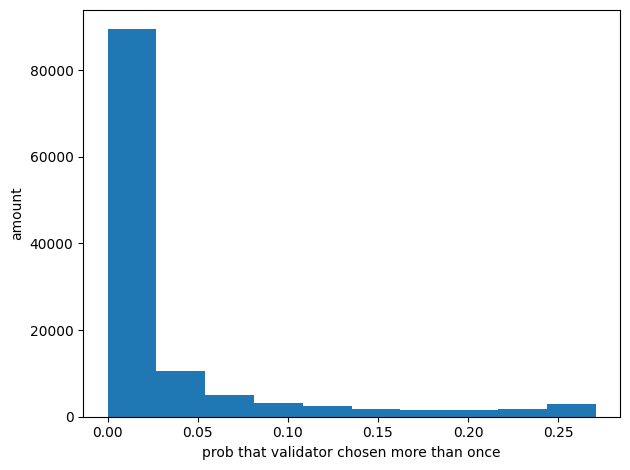

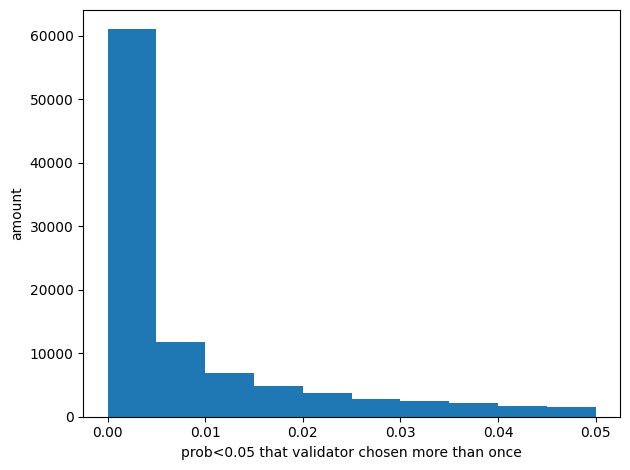

In [ ]:
plt.hist(p_values2,)
plt.xlabel('prob that validator chosen more than once')
plt.ylabel('amount')
plt.tight_layout()
plt.show()
plt.hist(p_values2[p_values2<0.05])
plt.xlabel('prob<0.05 that validator chosen more than once')
plt.ylabel('amount')
plt.tight_layout()
plt.show()

In [ ]:
(p_values2<0.05).sum()/len(p_values2)

0.8233120870708449

In [ ]:
suspit_df = date_index_count.loc[suspitios_pairs]

In [ ]:
suspit_valid = suspit_df.groupby('validator_index').count()
suspit_valid[suspit_valid['validators_cnt']>1].sort_values('validators_cnt', ascending=False)

,validators_cnt
validator_index,
232,6
28339,6
22606,6
27419,6
20784,6
...,...
20505,2
43199,2
20503,2


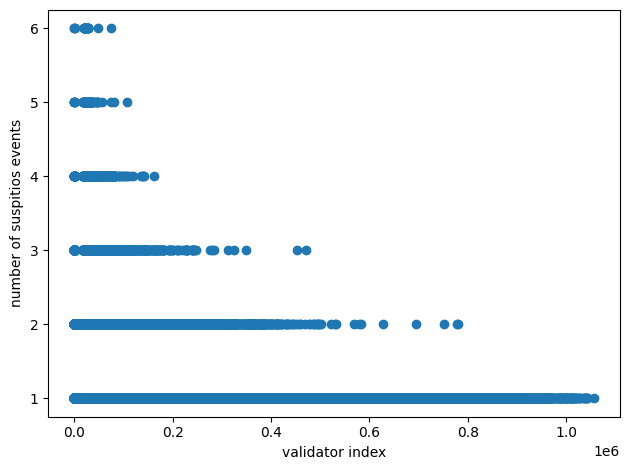

In [ ]:
plt.scatter(suspit_valid.index, suspit_valid)
plt.xlabel('validator index')
plt.ylabel('number of suspitios events')
plt.tight_layout()
plt.show()

### vadidators' smaller indexes tend to be included in more suspitios events than later ones

In [ ]:
suspit_date = suspit_df.groupby('slot_date').count()
suspit_date[suspit_date['validators_cnt']>1].sort_values('validators_cnt', ascending=False)

,validators_cnt
slot_date,
2020-12-29,349
2020-12-21,346
2020-12-26,343
2020-12-30,341
2020-12-24,336
...,...
2023-09-12,19
2023-11-21,19
2023-08-26,18


In [ ]:
df.nunique()

slot_date            1099
validator_index    841954
validators_cnt       1073
dtype: int64

# Every day there ocured at least 11 suspitios events. Some days they occure more often than others, let's plot and see how it distributed over the 3 years

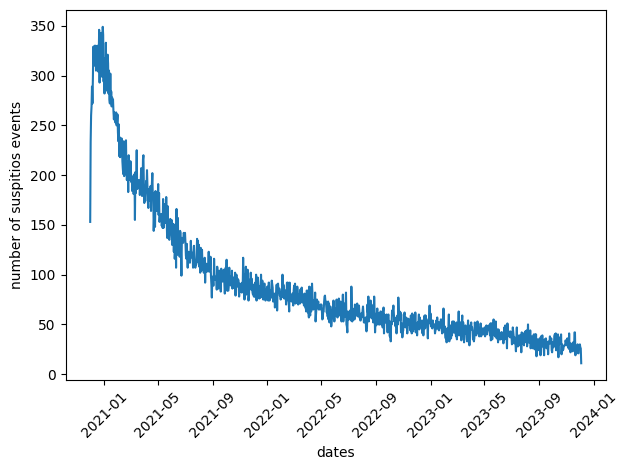

In [ ]:
plt.plot(suspit_date)
plt.xlabel('dates')
plt.xticks(rotation=45)
plt.ylabel('number of suspitios events')
plt.tight_layout()
plt.show()

# Summary: The choice of a validator is an independent event, so we can consider suspitios events as (almost) independent. Each day there ocures event of probability <(0.05)^11. It clearly indicates there is no randomnes, at least not in the manner described  in the task (Грубо кажучи якщо 1 поділіти на кільсть валідаторів(validators_cnt) це і є ймовірність бути назначеним як валідатор в конкретний слот.)

# It seems like the ongoing process is converging to random with time.